<h1 align="center">Quantum circuit tranpilation into rotations and introducing an informative measure of overhead at constant number of Qubits</h1>
<h4 align="center">Using Python & Qiskit</h4>
<h3 align="center">Mohamed Sami ShehabEldin</h3>
<h4 align="center">Zewail City of Science and Technology</h4>

-------

&nbsp;&nbsp;&nbsp;&nbsp; **It is known that quantum circuit overhead is proportional to the number of gates times the number of qubits, and it is usually used to compare the resource usage of different circuits. Here, I am introducing an informative measure (return a number) for circuits with the same number of qubits that does not only convey the number of gates but also how much it is effective in the circuit. For example, a circuit composed of 6 identities is not the same as a circuit contains 6 Pauli gates. This will be useful in physical realization, as quantum gates are physically realized by rotations,  and the new physical circuit will have the same dimensions. However, the same output can be done with different choices of rotations; one can choose many gates of small contributions or many redundant gates with high effect, or just the effective gates. In this work, I am making a function that transpiles the original circuit onto a physical circuit and introduces an informative measure that discriminates the mentioned situations; the measure proposes that the second circuit will have the highest overhead while the last one is the least.**

----

### Outline
<br>
<strong>
1. Task Definition (from QOSF application)
<br>
<br>
2. Circuit transpilation
<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1. Theory
<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.2. Function 1: parameters of unitary
<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.3. Function 2: gate to unitary
<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.4. Function 3: gate transpile
<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.5. Function 4: location range
<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.6. The Master Function: Quantum Circuit Transpiler
<br>
<br>
3. OverHead Analysis
<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.1. Quantifying Circuit Involvement <span style="color:red"> *(Genuinely)*</span>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;3.2. Reducing the overhead
<br>
<br>
Complementary Part: "Quantifying Circuit Involvement Implementation" (in this folder) 
<strong/>

------------

## 1. Task Definition (from QOSF application):

<img src="images/t3.png" width="600" height="500">

--------------

## 2. Circuit transpilation:

### 2.1. Theory:

As we want to transpile any single qubit gate into X and Y rotations, it comes to the mind a well known theorem states that any unitary U can be written as (Neilsen&Chuang P. 175):
$$
U = e^{i\alpha} R_z(\beta)R_y(\gamma)R_z(\delta)
$$
and this has equivlent form:
$$
U = e^{i\alpha} R_z(\beta)R_x(\gamma)R_z(\delta)
$$
This is my key for this task, as I can use it to transform any single qubit gate to $R_zR_xR_z$ and I can reduce any number of gates in series into just three rotation gates $R_zR_xR_z$.

### 2.2. Function 1: parameters of unitary

This function will get the 4 parameters $\alpha, \beta,\gamma, \delta$ for any given 2*2 unitary matrix. This based in the following analysis:
$$
U = e^{i\alpha} R_z(\beta)R_x(\gamma)R_z(\delta)=
\begin{pmatrix} 
e^{i(2\alpha-\beta-\delta)/2}cos(\frac{\gamma}{2}) & e^{i(2\alpha-\beta+\delta+3\pi)/2}sin(\frac{\gamma}{2})\\ e^{i(2\alpha+\beta-\delta+3\pi)/2}sin(\frac{\gamma}{2}) & e^{i(2\alpha+\beta+\delta)/2}cos(\frac{\gamma}{2}) 
\end{pmatrix}
$$

In [1]:
import numpy as np
from numpy.random import randint
import scipy.optimize

pii=np.pi

def par_of_unitary(unitary,message=False):
    unitry=np.array(unitary)
    
    re_u00=np.real(unitary[0][0])  #real part of first entry of unitary matrix
    im_u00=np.imag(unitary[0][0])  #imaginary part of first entry of unitary matrix
    re_u01=np.real(unitary[0][1])
    im_u01=np.imag(unitary[0][1])
    re_u10=np.real(unitary[1][0])
    im_u10=np.imag(unitary[1][0])
    re_u11=np.real(unitary[1][1])
    im_u11=np.imag(unitary[1][1])
    
    def equations(p):    #this is the set of equation came from equating the parameterized form with the given matrix
        a,b,c,f = p   #f is the phase, a,b,c are beta, gamma, delta
        
        f1=(np.cos((-a-c+2*f)/2)*np.cos(b/2)-re_u00)
        f2=(np.sin((-a-c+2*f)/2)*np.cos(b/2)-im_u00)
        f3=(np.cos((-a+c+2*f+3*pii)/2)*np.sin(b/2)-re_u01)
        f4=(np.sin((-a+c+2*f+3*pii)/2)*np.sin(b/2)-im_u01)
        f5=(np.cos((a-c+2*f+3*pii)/2)*np.sin(b/2)-re_u10)
        f6=(np.sin((a-c+2*f+3*pii)/2)*np.sin(b/2)-im_u10)
        f7=(np.cos((a+c+2*f)/2)*np.cos(b/2)-re_u11)
        f8=(np.sin((a+c+2*f)/2)*np.cos(b/2)-im_u11)
        
        return np.asarray((f1,f2,f3,f4,f5,f6,f7,f8,f8))
    
    #solving this set as homogoneus equation: f1=0,f2=0,...
    x = scipy.optimize.leastsq(equations, np.asarray((pii/2,pii/2,pii/2,pii/2)))[0]
    
    if message:
        print("The given unitary can be expressed as Rz({alpha})*Rx({beta})*Rz({gamma})*GlobalPhase({phi}))"
          .format(alpha=x[0],beta=x[1],gamma=x[2],phi=x[3]))
        print("Matching Error: ",equations(x))
    
    return x


**Example**:

In [2]:
u=np.array([[1,0],[0,1j]])

In [3]:
x=par_of_unitary(u,message=True)

The given unitary can be expressed as Rz(0.7853981566846657)*Rx(4.449004883289296e-19)*Rz(0.785398170110231)*GlobalPhase(0.7853981633974484))
Matching Error:  [ 0.00000000e+00  0.00000000e+00  1.57296077e-19 -1.57296075e-19
  1.57296075e-19 -1.57296077e-19 -1.60812265e-16  0.00000000e+00
  0.00000000e+00]


In [4]:
from qiskit import *
pii=np.pi
qc=QuantumCircuit(1)
if round(x[0],2)!=0.0: qc.rz(x[0],0)
if round(x[1],2)!=0.0: qc.rx(x[1],0)
if round(x[2],2)!=0.0: qc.rz(x[2],0)
backend = Aer.get_backend('unitary_simulator')
unitary = execute(qc,backend).result().get_unitary()
from qiskit_textbook.tools import array_to_latex
array_to_latex(unitary, pretext="\\text{Circuit = }\n")

<IPython.core.display.Math object>

In [5]:
qc.draw()

┌──────────┐┌──────────┐
q_0: ┤ RZ(pi/4) ├┤ RZ(pi/4) ├
     └──────────┘└──────────┘

Now, we can transform any given 2*2 unitary to Rz,Rx,Rz up to a phase. Usually, when executing a circuit with qiskit, it ignores the phase in get_unitary method.

### 2.3. Function 2: gate to unitary

The very logic step come after the ability of transformation of any unitary to z&x rotations, is to transform gates to unitaries. Qiskit have some problems in this tool so I do it myself (simple).

In [6]:
def gate_to_matrix(gate_data):   #gate data : qc.data[gate_number],
                                #this convey the regester and all gate information inside a circuit.
    gate_object=gate_data[0]    #gate info
    register_object=gate_data[1]  #register info, I.E target and control
    
    qc=QuantumCircuit(len(register_object))   #making new quantum circuit to get its equivlent unitary
    
    qc.append(gate_object,list(range(len(register_object)))) #adding the gate to the new circuit
    backend = Aer.get_backend('unitary_simulator')
    unitary = execute(qc,backend).result().get_unitary()   #extract its equivlent unitary
    return unitary

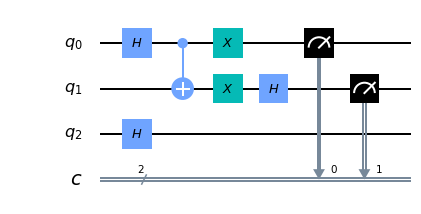

In [7]:
#example
qc1=QuantumCircuit(3,2)
qc1.h(0)
qc1.cx(0,1)
qc1.x([0,1])
qc1.h([1,2])
qc1.measure([0,1],[0,1])
qc1.draw("mpl")

In [8]:
gate_to_matrix(qc1.data[0])

array([[ 0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j],
       [ 0.70710678+0.00000000e+00j, -0.70710678+8.65956056e-17j]])

### 2.4. Function 3: gate transpile

I think now that my game has been revealed. Just after changing the gate to unitary we can change the unitary to the 3  x&y rotations gates. However, we did not mention CX gate, But the good news is:

<table><tr>
<td> <img src="images/cx1.png"  /> </td>
<td> <img src="images/cx2.png"  /> </td>
<td> <img src="images/cx3.png"  /> </td>

</tr></table>

These three circuits are all equivlent (as X=HZH), so we have to say to CX welcome to the group!

In [9]:
def gate_transpile(gate_data):
    gate_object=gate_data[0]     #gate info
    register_object=gate_data[1] #register info
    
    if len(register_object)==1:  #I.E if it is unitary on one qubit
        u=gate_to_matrix(gate_data)
        th=par_of_unitary(u)
        qc=QuantumCircuit(1)      #I will return this 1 register circuit
        if round(th[0],2)!=0.0: qc.rz(th[0],0)
        if round(th[1],2)!=0.0: qc.rx(th[1],0)
        if round(th[2],2)!=0.0: qc.rz(th[2],0)
            
    if len(register_object)==2:  #here I will consider that CX and CZ are the only multi registers gate
        qc=QuantumCircuit(2)    #i will return this 2 registers circuit
        pii=np.pi
        if gate_object.name=='cx':   #X=HZH=rz*rx*rz*z*rz*rx*rz, I will not use recursion for simplicity
            qc.rz(pii/2,register_object[1].index)
            qc.rx(pii/2,register_object[1].index)
            qc.rz(pii/2,register_object[1].index)
            qc.cz(register_object[0].index,register_object[1].index)
            qc.rz(pii/2,register_object[1].index)
            qc.rx(pii/2,register_object[1].index)
            qc.rz(pii/2,register_object[1].index)
    
    return qc
        
        

In [10]:
gate_transpile(qc1.data[2]).draw()

┌──────────┐┌────────┐┌──────────┐
q_0: ┤ RZ(pi/2) ├┤ RX(pi) ├┤ RZ(pi/2) ├
     └──────────┘└────────┘└──────────┘

### 2.5. Function 4: location range

Now in order to apply the resulting circuit of gate_transpile in the right place in the mirror circuit, I just have to to know the location range (initial to final register) of the original gate in the original circuit.

In [11]:
def location_range(register_object):
    ends=[register_object[0].index,register_object[-1].index]   #index of target and control registr
    rang=list(range(min(ends),max(ends)+1))   #making a sorted list of their range
    return rang

### 2.6. The Master Function: Quantum Circuit Transpiler

Now, we have all the needed functions to transpile an original circuit to a mirror circuit that only have gates belongs to the restricted group.

In [12]:
def qc_transpiler(qc):
    qn=qc.num_qubits     #number of quantum registers
    cn=qc.num_clbits     # --    -- classical --
    transpiled_qc=QuantumCircuit(qn,cn)   #the mirror circuit
    M=0   #to consider measurment
    for gate_data in qc.data:       #run on all gates in the original QC
        register_object=gate_data[1]  #register info

        if gate_data[0].name=="measure":    #considering the measurment
            transpiled_qc.measure(register_object[0].index,M)
            M=M+1
        else:   #other gates transpilation
            transpiled_gate=gate_transpile(gate_data)
            transpiled_qc.append(transpiled_gate,location_range(register_object))
        
    return transpiled_qc.decompose()

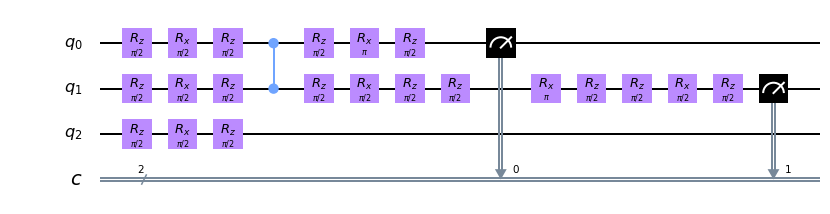

In [13]:
qc2=qc_transpiler(qc1)
qc2.draw("mpl")

----------

## 3. OverHead Analysis

### 3.1. Quantifying Circuit Involvement (Genuinely)

As mentioned in the statement of the task, the transpiled circuit is much more complicate and delicate or Involved. But how to quantify this Involvement? Let's call this measure "Involvement".

It may come to the mind that we can just count the number of gates in each cases and this will be a measure of the circuit delicacy. This may be write BUT Is the addition of $R_z(\pi)$ or $R_z(\frac{\pi}{2})$ or $R_z(\frac{\pi}{8})$ or $R_z(0.000001)$ contribute with the same Involvement?

I want to make a measure that capture that! That is having extra gates that have low effect (like $R_z(0.000001)$ or Identity) will contribute to the Involvement with less amount than having extra gates that are more effective. Note that Circuit depth does not capture that!

Abstractly, I will define the circuit A overhead from another circuit B to be:
$$
\bf{Overhead(A,B)=Involvement(A)-Involvement(B)}
$$

Now, I think that I have a regourous method that capture many things, I will introduce it as set of definitions then the intuition will be more obvious in the implementation part.

Define:

**StateTrip(i): The trace distance between the initial state and the new state just after the $i^{th}$ gate of the circuit.**

$$\bf{GateTrip(i) \equiv StateTrip(i) - StateTrip(i-1)}$$

Now, one can say Ok, let's make the involvment be the sum over all GateTrip(i), as this will capture how significant the gates are! but the problem is the a circuit A, and the same circuit with punsh of identities(small changes) applied everywhere will have the same measure. Also, I think this will be insufficient for gate replacement with equivlent gates. So, to measure how a circuit is delicate one should be delicate too!

I figuired out a similar way that can capture all of that, and I think it even capture more than I think!

$$
\bf{Involvement(A)= AreaUnder(StateTrip(i)) - |AreaUnder(StateTrip(i))-AreaUnder(gateTrip(i))|}
$$

where AreaUnder(StateTrip(i)) is just the area under the curve for the whole circuit (this can have a complicated and elegant form, but lets stay simple and sufficient).

This will be understood better in python implementation and results.


**Implementation this Idea in the other file inside this folder.**

**Implications:**
 * To reduce the Involvement we have to reduce the brutality of the existing gates and there numbers.
 * The Zero Involved circuit, must have no effective gates.

The Implementation and Results of this method is in "Quantifying Circuit Involvement Implementation" notebook.
Because Qiskit State Tomography cannot work after using it many times.
(BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.) (I failed in my search for this problem solution).

### 3.2. Reducing the overhead

As I have mentioned My key is:
$$
U = e^{i\alpha} R_z(\beta)R_x(\gamma)R_z(\delta)
$$
as I can transform any number of gates in series into just 3 gates.

$CZs$ make an obstacle in reducing the number of gates. Fortunately, $Z$ and $I$ commutes with $R_z$, so we can pass $R_z$ through the target gate! and then use $R_z(a)R_z(b)=R_z(a+b)$. we can do more non systematic reduction by using this concept of commutation, for example we can commute a series of pauli's twice, and this should be done case by case.

Making a function that takes a QC including arbitrary number of CZs and find each sequence of single gates then transform it int 3 rotation will be a long task that is not required. However, I can make a function that return the desired output if we just rewrite the gates of the transpiled circuit. What I mean is the following:

(This is ridiculous but I just want t apply the concept.)

In [14]:
#this is the function that transform any sequence of rotations gates into 3 rotations

def appendrots(qc, register, *instructions):
    '''
    qc=QuantumCircuit we will apply the sequence on, register= the register where we apply the sequnce
    instruction=gates instructions we seek to apply
    '''
    line=QuantumCircuit(1)    #the line that will carry the sequence
    
    for i in range(len(instructions)):  #run over all the instructions
        name=instructions[i].__getitem__(0).name   #name of the instruction
        theta=instructions[i].__getitem__(0).params[0] #parameter of the instruction
        if name=="rz":
            line.rz(theta,0)
        if name=="rx":
            line.rx(theta,0)
        #I can continue put if for all gates, but consider we just focus on a line of rotations.
        
    backend = Aer.get_backend('unitary_simulator')
    unitary = execute(line,backend).result().get_unitary()  #getting the corresponding unitary of the line
    x=par_of_unitary(unitary)      #getting the corresponding rotation parameters of the unitary

    
    if round(x[1],2)!=0.0:
        if round(x[0],2)!=0.0: qc.rz(x[0],register)
        qc.rx(x[1],register)
        if round(x[2],2)!=0.0: qc.rz(x[2],register)
    else:
        if round(x[0],2)!=0.0 or round(x[2],2)!=0.0: qc.rz(x[0]+x[2],register)


So in this section the user have to code a little part himself instead of just put inputs into a function.

Now, to reduced the overhead of the circuit in my example, we have to rewrite the instructions, this is ridiculous but I just want to apply the concept.

In [15]:
qc3=QuantumCircuit(3,2)   #reduced over head circuit
I=QuantumCircuit(3,2)   #for instructions

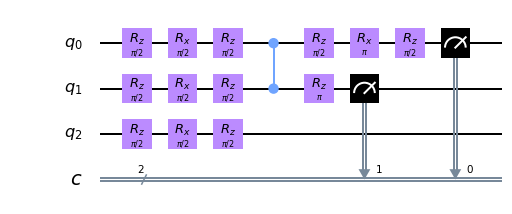

In [16]:
#the already 3 on sequence leave it
qc3.rz(pii/2,0)
qc3.rx(pii/2,0)
qc3.rz(pii/2,0)  
qc3.rz(pii/2,1)
qc3.rx(pii/2,1)
qc3.rz(pii/2,1)
qc3.cz(0,1)
qc3.rz(pii/2,0)
qc3.rx(pii,0)
qc3.rz(pii/2,0)
#for mare than 3 on sequnece we apply the function
appendrots(qc3,1,
            I.rz(pii/2,1),
            I.rx(pii/2,1),
            I.rz(pii/2,1),
            I.rz(pii/2,1),
            I.rx(pii,1),
            I.rz(pii/2,1),
            I.rz(pii/2,1),
            I.rx(pii/2,1),
            I.rz(pii/2,1))
qc3.rz(pii/2,2)
qc3.rx(pii/2,2)
qc3.rz(pii/2,2)

qc3.measure(0,0)
qc3.measure(1,1)

qc3.draw("mpl")

lets commute this $R_z$ over the target gate.

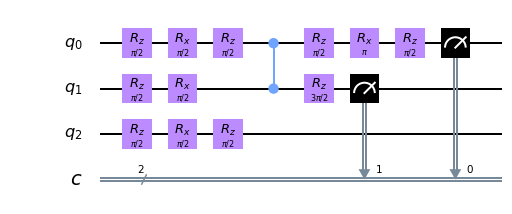

In [17]:
qc4=QuantumCircuit(3,2)   #reduced over head circuit
qc4.rz(pii/2,0)
qc4.rx(pii/2,0)
qc4.rz(pii/2,0)
qc4.rz(pii/2,1)
qc4.rx(pii/2,1)
qc4.cz(0,1)
qc4.rz(3*pii/2,1)
qc4.rz(pii/2,0)
qc4.rx(pii,0)
qc4.rz(pii/2,0)
qc4.rz(pii/2,2)
qc4.rx(pii/2,2)
qc4.rz(pii/2,2)
qc4.measure(0,0)
qc4.measure(1,1)
qc4.draw("mpl")

As we see, the number of gates reduced keeping all existing gate belong to the restricted group.

The overhead difference is in the "Quantifying Circuit Involvement Implementation" notebook.

<span style="color:blue">some *blue* text</span>.
